In [30]:
import numpy as np
from scipy.linalg import get_lapack_funcs
from scipy.linalg import lu

from itertools import combinations

from time import time
import matplotlib.pyplot as plt

In [24]:
# A.shape = (N, r), where N > r
# Searching for n×r submatrix of maximal volume
def rect_maxvol(A, n, tol=1., start_maxvol_iters=10, tmp_index=None, C=None):

    tol2 = tol**2
    N, r = A.shape

    index = np.zeros(N, dtype=np.int32)
    chosen = np.ones(N)
    if tmp_index is None:
        tmp_index, C = maxvol(A, 1.05, start_maxvol_iters)
    index[:r] = tmp_index
    chosen[tmp_index] = 0
    C = np.asfortranarray(C)
    row_norm_sqr = np.array([chosen[i]*np.linalg.norm(C[i], 2)**2 for
        i in range(N)])
    i = np.argmax(row_norm_sqr)
    K = r

    while (K < n): #row_norm_sqr[i] > tol2 and 
        index[K] = i
        chosen[i] = 0
        c = C[i].copy()
        v = C.dot(c.conj())
        l = 1.0/(1+v[i])
        C = -l * np.expand_dims(v, 1) @ np.expand_dims(c, 0) + C

        C = np.hstack([C, l*v.reshape(-1,1)])
        row_norm_sqr -= (l*v*v.conj()).real
        row_norm_sqr *= chosen
        i = row_norm_sqr.argmax()
        K += 1
    return index[:K].copy(), C

In [3]:
# A.shape = (N, r), where N > r
def maxvol(A, tol=1.05, max_iters=100):

    if tol < 1:
        tol = 1.0
    N, r = A.shape
    
    B = np.copy(A, order='F')
    C = np.copy(A.T, order='F')
    H, ipiv, _ = get_lapack_funcs('getrf', [B])(B, overwrite_a=1)
    index = np.arange(N, dtype=np.int32)
    for i in range(r):
        tmp = index[i]
        index[i] = index[ipiv[i]]
        index[ipiv[i]] = tmp
    # solve A = CH, H is in LU format
    B = H[:r]
    # It will be much faster to use *TRSM instead of *TRTRS
    trtrs = get_lapack_funcs('trtrs', [B])
    trtrs(B, C, trans=1, lower=0, unitdiag=0, overwrite_b=1)
    trtrs(B, C, trans=1, lower=1, unitdiag=1, overwrite_b=1)
    # C has shape (r, N) -- it is stored transposed
    # find max value in C
    i, j = divmod(abs(C).argmax(), N)
    iters = 0
    while abs(C[i,j]) > tol and iters < max_iters:
        index[i] = j
        tmp_row = C[i].copy()
        tmp_column = C[:,j].copy()
        tmp_column[i] -= 1.
        alpha = -1./C[i,j]
        C = alpha * np.expand_dims(tmp_column, 1) @ np.expand_dims(tmp_row, 0) + C
        iters += 1
        i, j = divmod(abs(C).argmax(), N)
    return index[:r].copy(), C.T

In [4]:
def maxvol2(A, I, n):

    M, r = A.shape
    current_order = np.array(list(I) + list(set(np.arange(M)).difference(set(I))))
    C = A[current_order] @ np.hstack([np.linalg.pinv(A[I]), np.zeros((r, n - r))]) #M * n
    l = np.linalg.norm(C, axis=1) ** 2
    l[:r] = 0
    for new_size in range(r, n):
        i = np.argmax(l)
        l_prime_i = l[i] + 1 # number
        l[i] = 0
        C_prime = C @ C[[i]].T / (l_prime_i)
        C = C - C_prime @ C[[i]]
        l[:new_size] = l[:new_size] - l_prime_i * np.linalg.norm(C[:new_size], axis=1) ** 2

        C[:, new_size] = C_prime.reshape(M)

        current_order[i], current_order[new_size] = current_order[new_size], current_order[i]

        C[[i, new_size]] = C[[new_size, i]]
        l[i], l[new_size] = l[new_size], l[i]


    I = current_order[:n]

    return I


In [5]:
def householder(x):
    alpha = x[0]
    s = np.power(np.linalg.norm(x[1:]), 2)
    v = x.copy()

    if s == 0:
        tau = 0
    else:
        t = np.sqrt(alpha**2 + s)
        v[0] = alpha - t if alpha <= 0 else -s / (alpha + t)

        tau = 2 * v[0]**2 / (s + v[0]**2)
        v /= v[0]
    return tau, v.reshape((v.shape[1], 1))

def EffectiveHouseholderMaxvol2(A, I, n):
    M, r = A.shape
    k = I.shape[0]
    
    current_order = np.array(list(I) + list(set(np.arange(M)).difference(set(I))))
    A_hat = A[I]
    C = (A[current_order] @ np.linalg.pinv(A_hat))[r:]
    l = np.linalg.norm(C, axis=1) ** 2
    
    for new_size in range(n - r):
        i = np.argmax(l)
        current_order[[new_size + r, i + r]] = current_order[[i + r, new_size + r]]
        l_i_prime = 1 + l[i]
        l[i] = l[new_size]
        l[new_size] = 0
        C_I = C[[i]]
        C[[i]] = C[[new_size]]
        C[[new_size]] = np.zeros((1, r))    
        tau, v = householder(C_I)
        C = C - tau * (C @ v) @ v.T
        l[new_size:] = l[new_size:] - (1 - 1 / l_i_prime) * C[np.ix_(np.arange(new_size, M - r), np.array([0]))].reshape(M - r - new_size)
        C[:,[0]] = C[:,[0]] * (l_i_prime ** -0.5)
    return current_order[:n]

In [101]:
r, n = 20, 30
Nexps = 30
rects_mean_N, maxvs2_mean_N, houses_mean_N = [], [], []
Ns = range(300, 3000, 100)
for N in Ns:
    rects, maxvs2, houses = [], [], []
    for _ in range(Nexps):
        A = np.random.random((N, r))
        p, C = maxvol(A, max_iters=10)
        t1 = time()
        EffectiveHouseholderMaxvol2(A, p, n)
        t2 = time()
        houses.append(t2-t1)
        maxvol2(A, p, n)
        t3 = time()
        maxvs2.append(t3-t2)
        p, C = rect_maxvol(A, n, tmp_index=p, C=C)
        t4 = time()
        rects.append(t4-t3)
    rects_mean_N.append(sum(rects) / Nexps)
    maxvs2_mean_N.append(sum(maxvs2) / Nexps)
    houses_mean_N.append(sum(houses) / Nexps)

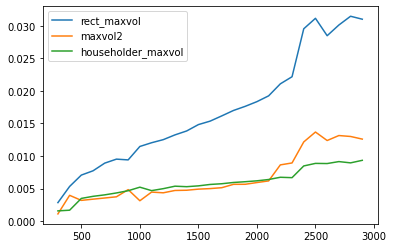

In [102]:
plt.plot(list(Ns), rects_mean_N, label="rect_maxvol")
plt.plot(list(Ns), maxvs2_mean_N, label="maxvol2")
plt.plot(list(Ns), houses_mean_N, label="householder_maxvol")
plt.legend()

In [105]:
r, n = 10, 20
Nexps = 30
rects_mean_N, maxvs2_mean_N, houses_mean_N = [], [], []
Ns = range(300, 3000, 100)
for N in Ns:
    rects, maxvs2, houses = [], [], []
    for _ in range(Nexps):
        A = np.random.random((N, r))
        p, C = maxvol(A, max_iters=10)
        t1 = time()
        EffectiveHouseholderMaxvol2(A, p, n)
        t2 = time()
        houses.append(t2-t1)
        maxvol2(A, p, n)
        t3 = time()
        maxvs2.append(t3-t2)
        p, C = rect_maxvol(A, n, tmp_index=p, C=C)
        t4 = time()
        rects.append(t4-t3)
    rects_mean_N.append(sum(rects) / Nexps)
    maxvs2_mean_N.append(sum(maxvs2) / Nexps)
    houses_mean_N.append(sum(houses) / Nexps)

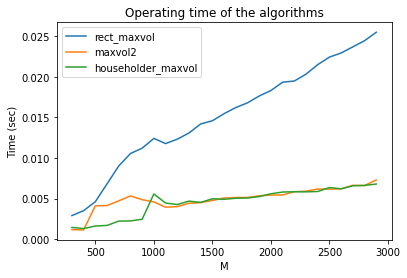

In [110]:
plt.plot(list(Ns), rects_mean_N, label="rect_maxvol")
plt.plot(list(Ns), maxvs2_mean_N, label="maxvol2")
plt.plot(list(Ns), houses_mean_N, label="householder_maxvol")
plt.xlabel("M")
plt.ylabel("Time (sec)")
plt.legend()
plt.title("Operating time of the algorithms")
plt.show()

In [67]:
r, N = 10, 600
Nexps = 10
rects_mean, maxvs2_mean, houses_mean = [], [], []
ns = range(30, 600, 30)
for n in ns:
    rects, maxvs2, houses = [], [], []
    for _ in range(Nexps):
        A = np.random.random((N, r))
        p, C = maxvol(A, max_iters=10)
        t1 = time()
        EffectiveHouseholderMaxvol2(A, p, n)
        t2 = time()
        houses.append(t2-t1)
        maxvol2(A, p, n)
        t3 = time()
        maxvs2.append(t3-t2)
        p, C = rect_maxvol(A, n, tmp_index=p, C=C)
        t4 = time()
        rects.append(t4-t3)
    rects_mean.append(sum(rects) / Nexps)
    maxvs2_mean.append(sum(maxvs2) / Nexps)
    houses_mean.append(sum(houses) / Nexps)

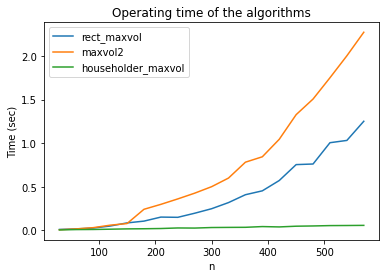

In [111]:
plt.plot(list(ns), rects_mean, label="rect_maxvol")
plt.plot(list(ns), maxvs2_mean, label="maxvol2")
plt.plot(list(ns), houses_mean, label="householder_maxvol")
plt.xlabel("n")
plt.ylabel("Time (sec)")
plt.legend()
plt.title("Operating time of the algorithms")
plt.show()

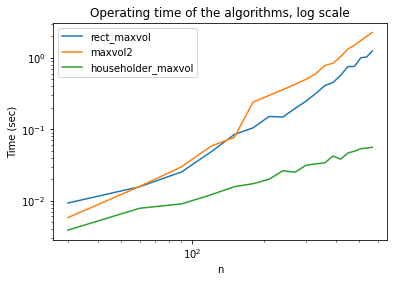

In [114]:
plt.plot(list(ns), rects_mean, label="rect_maxvol")
plt.plot(list(ns), maxvs2_mean, label="maxvol2")
plt.plot(list(ns), houses_mean, label="householder_maxvol")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("Time (sec)")
plt.legend()
plt.title("Operating time of the algorithms, log scale")
plt.show()

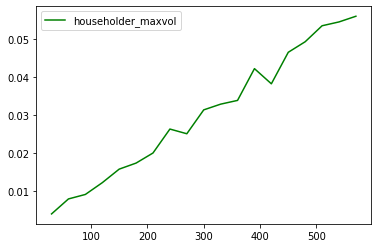

In [113]:
plt.plot(list(ns), houses_mean, label="householder_maxvol", color='g')
plt.legend()